In [71]:
from itertools import combinations
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
import seaborn as sns
import matplotlib.pyplot as plt
import dcor # pip install dcor
import xgboost
from sklearn.model_selection import train_test_split

In [78]:
def flatten(tup):
    """ 
    Flatten any nested tuple
    """
    if len(tup) < 1:
        return tup 
    if isinstance(tup[0], tuple):
        return flatten(tup[0]) + flatten(tup[1:])
    return tup[:1] + flatten(tup[1:])


def calc_shapley_value(player_index, all_players, cf_dict):
    """
    Calculate the Shapley value for player index
    Input:
        all_players, list of player indices
        cf_dict, dictionary containing characteristic function values for all players
    """
    players = all_players.copy()

    if player_index in players:
        players.remove(player_index)

    num_players = len(players)
    coalition_sizes = list(range(num_players+1))
    value = 0
    player_tuple = (player_index,)

    for _size in coalition_sizes:
        coalition_value = 0
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            value_in_coalition = (cf_dict[tuple(sorted(_coalition + player_tuple))] - cf_dict[_coalition])
            coalition_value += value_in_coalition

        average_coalition_value = coalition_value/len(coalitions_of_size_s)
        value += average_coalition_value
    average_value = value/len(coalition_sizes)

    return average_value

def calc_shapley_values(x, y, cf_dict):
    """
    Returns the shapley values for features x and labels y, given a
    characteristic function (default dcor)
    """
    
    players = list(range(x.shape[1]))
    shapley_values = []
    for _player in players:
        shapley_values.append(calc_shapley_value(_player, players, cf_dict))
    return shapley_values

def make_cf_dict(x, y, characteristic_function):
    """ 
    Creates dictionary with values of the characteristic function for each
    combination of the players.
    """
    cf_dict = {}
    num_players = x.shape[1]
    players = list(range(num_players))
    coalition_sizes = list(range(num_players+1))

    for _size in coalition_sizes:
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            _coalition = tuple(sorted(flatten(_coalition)))
            cf_dict[_coalition] = characteristic_function(x, y, _coalition)

    return cf_dict

def sort_shapley_values(values, features):
    return zip(*sorted(zip(values, features), reverse=True))

# The Shapley decomposition

### Cab sharing 1

In [4]:
players = [1,2,3]
cf_dict = {():0, (1,):3, (2,):7, (3,):10, 
           (1,2):7, (1,3):10, (2,3):10, 
           (1,2,3):10}

print(calc_shapley_value(1, players, cf_dict))
print(calc_shapley_value(2, players, cf_dict))
print(calc_shapley_value(3, players, cf_dict))

1.0
3.0
6.0


### Cab sharing 2

In [7]:
players = [1,2,3,4]
cf_dict = {():0, (1,):0, (2,):3, (3,):3, (4,):7, 
           (1,2):3, (1,3):3, (1,4):7, (2,3):3, (2,4):7, (3,4):7, 
           (1,2,3):3, (1,2,4):7, (1,3,4):7, (2,3,4):7, 
           (1,2,3,4):7}

print(calc_shapley_value(1, players, cf_dict))
print(calc_shapley_value(2, players, cf_dict))
print(calc_shapley_value(3, players, cf_dict))
print(calc_shapley_value(4, players, cf_dict))

0.0
1.0
1.0
5.0


### Cat and mice

In [6]:
players = [1,2,3]
cf_dict = {():0, (1,):2, (2,):4, (3,):5, (1,2):3, (1,3):3, (2,3):2, (1,2,3):3}
print(calc_shapley_value(1, players, cf_dict))
print(calc_shapley_value(2, players, cf_dict))
print(calc_shapley_value(3, players, cf_dict))

0.5
1.0
1.5


## Data and correlation

In [55]:
X_data, y_data = load_diabetes(scaled=True, as_frame=True, return_X_y=True)
features = X_data.columns.to_numpy()
features

array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
      dtype=object)

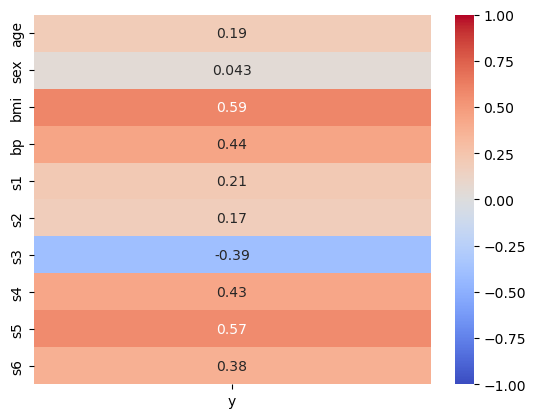

In [82]:
df = pd.concat([X_data, y_data.rename("y")], axis=1)
corr = df.corr(numeric_only=True)
sns.heatmap(corr.loc[X_data.columns, ["y"]], annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

## The Shapley value for the target, using as characteristic function the linear correlation R²

In [35]:
def characteristic_function_r2(x, y, coalition):
    """
    Returns the characteristic function value (currently the coefficient of determination)
    Input:
        x, numpy array shape (#samples, #features)        
        y, numpy array shape (#samples, )
        coalition, tuple of indices of features to include
    """
    if len(coalition)==0:
        return 0.0
    x = x[:, coalition]
    
    # --- Coefficient of determination, R2
    det_C_xy = np.linalg.det(np.corrcoef(x.T, y))
    if len(coalition)==1:
        det_C_x = 1
    else:
        det_C_x = np.linalg.det(np.corrcoef(x.T))

    return (1 - det_C_xy/det_C_x)

In [54]:
cf_dict_R2 = make_cf_dict(X_data.to_numpy(), y_data.to_numpy(), characteristic_function_r2)
print(len(cf_dict_R2))
print(2**len(features))

1024
1024


In [65]:
shapley_values = calc_shapley_values(X_data.to_numpy(), y_data.to_numpy(), cf_dict_R2)

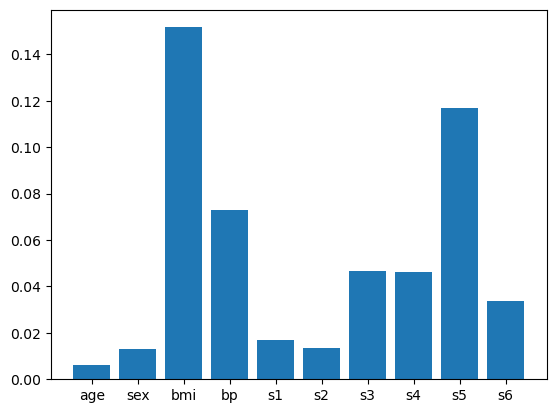

In [64]:
plt.bar(range(len(shapley_values)), shapley_values)
plt.xticks(range(len(shapley_values)), features)
plt.show()

In [67]:
print("Sum of the Shapley values: ", sum(shapley_values))
print("Value of the grand coalition: ", cf_dict_R2[list(cf_dict_R2.keys())[-1]])

Sum of the Shapley values:  0.517748422220345
Value of the grand coalition:  0.517748422220345


## The Shapley value for the target, using as characteristic function the distance correlation

In [72]:
def characteristic_function_dcor(x, y, coalition):
    if len(coalition)==0:
        return 0.0

    x = x[:, coalition]
    
    return dcor.distance_correlation(x,y)

In [76]:
cf_dict_dcor = make_cf_dict(X_data.to_numpy(), y_data.to_numpy(), characteristic_function_dcor)
shapley_values_dcor = calc_shapley_values(X_data, y_data, cf_dict_dcor)

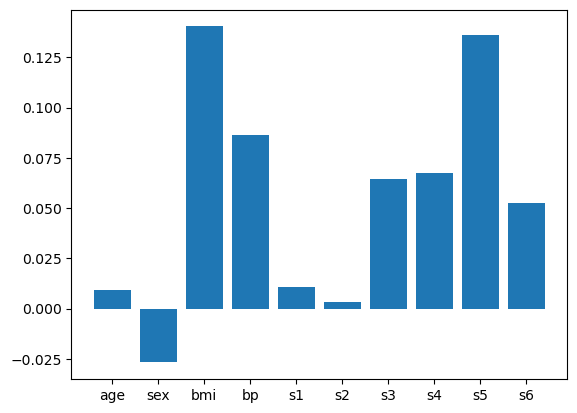

In [77]:
plt.bar(range(len(shapley_values_dcor)), shapley_values_dcor)
plt.xticks(range(len(shapley_values_dcor)), features)
plt.show()

In [79]:
_, sorted_features = sort_shapley_values(shapley_values, features)
print(sorted_features)
_, sorted_features_dcor = sort_shapley_values(shapley_values_dcor, features)
print(sorted_features_dcor)

('bmi', 's5', 'bp', 's3', 's4', 's6', 's1', 's2', 'sex', 'age')
('bmi', 's5', 'bp', 's4', 's3', 's6', 's1', 'age', 's2', 'sex')


# Shapley values for a model

### Train and evaluate regressor

In [86]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

regressor = xgboost.XGBRegressor()
regressor.fit(x_train, y_train);

In [96]:
y_pred = regressor.predict(x_test)

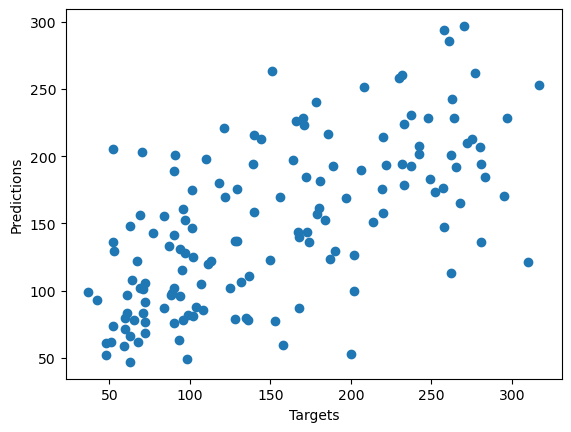

In [108]:
plt.scatter(y_test, y_pred)
plt.xlabel("Targets")
plt.ylabel("Predictions")
plt.show()

### Compare Shapley values for target and predictions

In [101]:
cf_dict_dcor_targets = make_cf_dict(x_test.to_numpy(), y_test.to_numpy(), characteristic_function_dcor)
shapley_values_targets = calc_shapley_values(x_test.to_numpy(), y_test.to_numpy(), cf_dict_dcor_targets)

In [100]:
cf_dict_dcor_preds = make_cf_dict(x_test.to_numpy(), np.array(y_pred), characteristic_function_dcor)
shapley_values_preds = calc_shapley_values(x_test.to_numpy(), np.array(y_pred), cf_dict_dcor_preds)

In [106]:
def plot_shapley_comparison(values_0, values_1,feature_names=None, nametags=[0,1]):
    assert len(values_0) == len(values_1)
    num = range(1,len(values_0)+1)
    colors = ["blue", "pink"]
    
    for _n, _values in enumerate([values_0, values_1]):
        _col = colors[_n]
        plt.scatter(num,_values,c=_col,marker='s',alpha=0.7,label=f"Shapley values {nametags[_n]}")

    plt.ylabel("Shapley values")
    plt.legend()
    if feature_names is not None:
        ax = plt.gca()
        ax.set_xticks(num)
        ax.set_xticklabels(feature_names,rotation=45)
    plt.show()

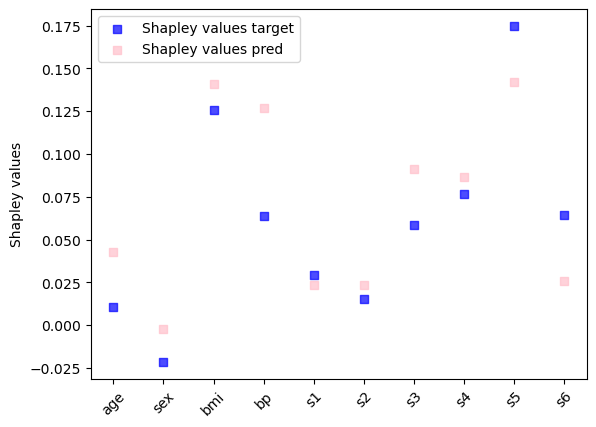

In [107]:
plot_shapley_comparison(shapley_values_targets, shapley_values_preds, features, ["target", "pred"])